In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
import pandas as pd
import numpy as np
import os
from os.path import join, isdir, dirname, basename, exists
import itertools

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(context="paper",style="white",font_scale=1.25)
from glob import glob

import matplotlib as mpl

In [3]:
eCON= '/data/bswift-1/Pessoa_Lab/eCON'
DATPAT = join(eCON,'onsetdir/{subj}/subj{subj}_run{run}.dat')
yoked = pd.read_excel(join(eCON,'onsetdir/CON_yoked_table.xlsx'))
yoked = yoked.query('use == 1')

In [4]:
DATPAT.format(subj='001',run=0)

'/data/bswift-1/Pessoa_Lab/eCON/onsetdir/001/subj001_run0.dat'

In [5]:
# load the data from the .dat (json) file into a dictionary  
from json import load

path = DATPAT.format(subj='CON016', run=0)
with open(path, 'r') as f:
    data = load(f)

In [6]:
from pprint import pprint
pprint(data, depth=1, compact=True)

{'BlockDur': [...],
 'BlockOffset': [...],
 'BlockOnset': [...],
 'DiffProgress': [...],
 'Escapes': [...],
 'Quit': [],
 'RunDur': 455.0000139699764,
 'ShockDur': [...],
 'ShockLvl': '3.5',
 'ShockOffset': [...],
 'ShockOnset': [...],
 'nonEscapes': [...],
 'ySubj': 'CON007'}


In [7]:
df = pd.DataFrame()
shock_durs = []

for i, row in yoked.iterrows():
    subj = row['uncontrol']
    runs = np.arange(6)[row.loc['run0':'run5'].astype(bool)]
    for j, run in enumerate(runs):
        path = DATPAT.format(subj=subj, run=run)
        with open(path, 'r') as f:
            data = load(f)
            
        numEsc = len(list(itertools.chain(*data['Escapes'])))
        numNonEsc = len(data['nonEscapes'])
        tmp_df_uncon = pd.DataFrame(['P{:02d}'.format(i),'uncontrol',subj,j,numNonEsc],index=['Pair','Group','Subject','run','buttPress']).T
        tmp_df_con = pd.DataFrame(['P{:02d}'.format(i),'control',row['control'],j,numEsc],index=['Pair','Group','Subject','run','buttPress']).T
        df = pd.concat([df,tmp_df_con,tmp_df_uncon],axis=0,ignore_index=True)
        
        shock_durs.extend(data['ShockDur'])

Text(0.5, 1.0, 'Shock Durations')

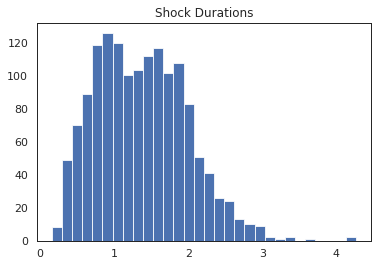

In [8]:
_=plt.hist(shock_durs,bins = 30)
plt.title('Shock Durations')

In [9]:
summed_df = df.groupby(['Pair','Group','Subject'])['buttPress'].sum().reset_index()

In [10]:
summed_df.set_index('Pair',inplace=True)

In [17]:
summed_df.groupby('Group')['buttPress'].agg(['mean','std'])

,mean,std
Group,,
control,173.163934,18.010349
uncontrol,132.278689,55.835213


In [10]:
diff_df = summed_df[summed_df.Group == 'uncontrol']['buttPress'].subtract(summed_df[summed_df.Group == 'control']['buttPress']).to_frame('Y')
diff_df.head()

,Y
Pair,
P00,-87
P01,-21
P02,-57
P03,-23
P04,-83


In [11]:
diff_df.to_csv('buttonPressDiff.csv')

### Add difference in button press as a covariate

In [12]:
def perm_rel_sample(samp,n_perms=10000):
    n, k, samp_dist = len(samp), 0, []
    mean_h1 = np.abs(np.mean(samp))
    for n in range(n_perms):
        mean_h0 = np.mean([val*np.random.choice([1,-1],) for val in samp])
        samp_dist.append(mean_h0)
        k += np.abs(mean_h0) > mean_h1
    return(samp_dist,(k+1)/(n_perms+1))

In [13]:
samp_dist, p_val = perm_rel_sample(diff_df.Y,10000)

In [14]:
from scipy.stats import ttest_1samp
print('Paired Samples T-test p-value: %.8f' %(ttest_1samp(diff_df.Y,0)[1]))
print('Paired Samples permutation test p-value: %.8f' %(p_val))

Paired Samples T-test p-value: 0.00000015
Paired Samples permutation test p-value: 0.00019998


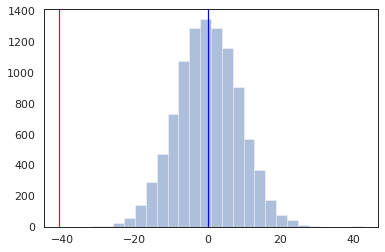

In [15]:
_=plt.hist(samp_dist,bins=25,alpha=0.45)
plt.axvline(x=np.mean(diff_df.Y),c='red',label='Observed mean')
plt.axvline(x=np.mean(samp_dist),c='blue',label='Mean of \nsampling dsitribution')

Text(0.5, 0, 'Number of button press: (uncontrol-control)')

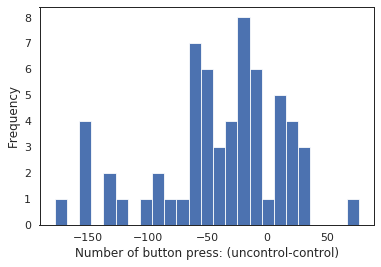

In [16]:
diff_df.Y.plot(kind='hist',bins=25)
plt.xlabel('Number of button press: (uncontrol-control)')

In [38]:
from sklearn.preprocessing import StandardScaler

stdz = StandardScaler()
diff_df_stdz = pd.DataFrame(stdz.fit_transform(diff_df),columns=diff_df.columns,index=diff_df.index)
diff_df_stdz.head()

,Y
Pair,
P00,-0.866438
P01,0.373619
P02,-0.302776
P03,0.336041
P04,-0.791283


In [17]:
con_df = pd.DataFrame(columns=['Subject','run','trial','buttPress'])
for i, row in yoked.iterrows():
    subj = row['uncontrol']
    runs = np.arange(6)[row.loc['run0':'run5'].astype(bool)]
    for j, run in enumerate(runs,start=1):
        path = DATPAT.format(subj=subj, run=run)
        with open(path, 'r') as f:
            data = load(f)
        
        for k,event in enumerate(data['Escapes'],start=1):
            tmp_df = pd.DataFrame([data['ySubj'],j,k,len(event)],index=['Subject','run','trial','buttPress']).T
            con_df = con_df.append(tmp_df,ignore_index=True)
            
con_df['buttPress'] = con_df['buttPress'].astype(float)

Text(0.5, 0, '(Run, Trial)')

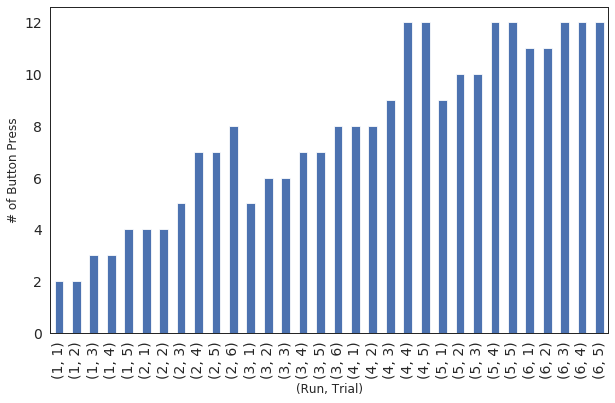

In [18]:
con_df.groupby(['run','trial'])['buttPress'].mean().round().plot('bar',figsize=(10,6),fontsize=14)
plt.ylabel('# of Button Press')
plt.xlabel('(Run, Trial)')

$$y = \beta_{0} + \beta_{SM} + \beta_{TM} + \beta_{SD} + \beta_{TD}$$

$$y = \beta_{0} + \beta_{SM}SM + \beta_{TM}TM + \beta_{SD}SD + \beta_{TD}TD + \epsilon$$

Where,  
SM: State mean  
TM: Trait mean  
SD: State difference  
TD: Trait difference

$y$: can be, 
1. difference (uncon-con) in the ROI shock response
2. difference in the SCR-ROI shock correlation values
3. difference in the number of button presses

$\beta_{0}$ is of interest

